<a href="https://colab.research.google.com/github/casalazara/Data-Science-Aplicado/blob/master/Lab4/L4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas-profiling==2.7.1

## Librerías a usar

In [2]:
import pandas as pd
import numpy as np
import scipy.stats  as stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency

import requests
import zipfile

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import pandas_profiling

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Descarga de datos

In [3]:
def download_content(url):
    r = requests.get(url)
    with open('bank-additional.zip', "wb") as f:
        f.write(r.content)
    return
download_content('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip')

with zipfile.ZipFile('bank-additional.zip', 'r') as zip_ref:
    zip_ref.extractall('zip')



## Lectura de datos

In [4]:
df = pd.read_csv('zip/bank-additional/bank-additional-full.csv',delimiter=";")
df.head()

age        job  marital  ... euribor3m nr.employed   y
0   56  housemaid  married  ...     4.857      5191.0  no
1   57   services  married  ...     4.857      5191.0  no
2   37   services  married  ...     4.857      5191.0  no
3   40     admin.  married  ...     4.857      5191.0  no
4   56   services  married  ...     4.857      5191.0  no

[5 rows x 21 columns]

## Generación de reporte

In [5]:
pandas_profiling.ProfileReport(df)

## Entendimiento del negocio
Los datos están relacionados con campañas de marketing de una entidad financiera portuguesa. Las campañas de marketing se basaron en llamadas a teléfono y celular. El dataframe con tiene 41188 observaciones y 21 variables, de estas 10 son categóricas, 10 numéricas y 1 tipo boolean o binaria. Las variables contienen información demográfica del cliente, información relacionada con el último contacto de la última campaña, información del contexto social y económico e información del cliente con respecto a otras campañas.

En este [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing) se puede encontrar información más detallada respecto a las variables 
## Proceso de limpieza

*   Los tipos de las variables fueron identificados correctamente por pandas al cargar el archivo 
*   Hay 12 filas duplicadas, dado el contexto el problema no se deben eliminar pues pueden corresponder a llamadas realizadas al mismo cliente.
*   Todos los datos están completos
*   La mayoria de los datos representan la realidad de acuerdo a la información de las variables en el [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Sin embargo, hay variables que tienen unknown en sus valores posibles y en pequeña cantidad, estas variables corresponden a información demográfica del cliente por lo que para efectos del objetivo del proyecto es importante eliminar estas filas con estos valores.
*   Las variables que no son de interés son aquellas que están relacionadas con el mes, duración del contacto (llamada) y días transcurridos entre la llamada de una campaña previa y la actual pues las dos primeras no son útiles para plantear alguna hipótesis y para la última, mejor que saber cuantos días transcurrieron es saber el número de contactos previos (previous). Asimismo, la variable default dada la gran cantidad de valores unknown no es de interés para las hipótesis.

### Tipos de datos

In [6]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

### Duplicados

In [7]:
df[df.duplicated()==True]

age          job   marital  ... euribor3m nr.employed    y
1266    39  blue-collar   married  ...     4.855      5191.0   no
12261   36      retired   married  ...     4.966      5228.1   no
14234   27   technician    single  ...     4.962      5228.1   no
16956   47   technician  divorced  ...     4.962      5228.1   no
18465   32   technician    single  ...     4.968      5228.1   no
20216   55     services   married  ...     4.965      5228.1   no
20534   41   technician   married  ...     4.966      5228.1   no
25217   39       admin.   married  ...     4.153      5195.8   no
28477   24     services    single  ...     1.423      5099.1   no
32516   35       admin.   married  ...     1.313      5099.1   no
36951   45       admin.   married  ...     1.072      5076.2  yes
38281   71      retired    single  ...     0.742      5017.5   no

[12 rows x 21 columns]

### Completitud

In [8]:
def completitud(df):
  mis_val = df.isnull().sum()
  mis_val_percent = 100 * (1 - (df.isnull().sum()/len(df)))
  mis_val_percent.rename_axis('Atributo',inplace=True)
  return mis_val_percent
completitud(df)

Atributo
age               100.0
job               100.0
marital           100.0
education         100.0
default           100.0
housing           100.0
loan              100.0
contact           100.0
month             100.0
day_of_week       100.0
duration          100.0
campaign          100.0
pdays             100.0
previous          100.0
poutcome          100.0
emp.var.rate      100.0
cons.price.idx    100.0
cons.conf.idx     100.0
euribor3m         100.0
nr.employed       100.0
y                 100.0
dtype: float64

### Exactitud

Podemos ver que las variables job, marital, education, default, housing y loan contienen valores "unknown" por lo que es mejor eliminar las filas que contengan estos valores siempre y cuando tengan pocas filas que los incluyan.

In [9]:
for columna in df.columns:
  print(columna,"\n",df[columna].unique())

age 
 [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
job 
 ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital 
 ['married' 'single' 'divorced' 'unknown']
education 
 ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default 
 ['no' 'unknown' 'yes']
housing 
 ['no' 'yes' 'unknown']
loan 
 ['no' 'yes' 'unknown']
contact 
 ['telephone' 'cellular']
month 
 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week 
 ['mon' 'tue' 'wed' 'thu' 'fri']
duration 
 [ 261  149  226 ... 1246 1556 1868]
campaign 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37

Veremos la cantidad de filas que tienen unknown en los valores de las columnas job, marital, education, housing, loan y default para determinar si se pueden eliminar o no algunas filas.

In [10]:
cols = ['job','marital','education','housing','loan','default']
for col in cols:
  print(pd.value_counts(df[col]))

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64
no         32588
unknown     8597
yes            3
Name: default, dtype: int64


In [11]:
cols = ['job','marital','education','housing','loan']
for col in cols:
  df = df[df[col]!='unknown']
print(f"Quedan {df.shape[0]} filas y {df.shape[1]} columnas")
df.head()

Quedan 38245 filas y 21 columnas


age        job  marital  ... euribor3m nr.employed   y
0   56  housemaid  married  ...     4.857      5191.0  no
1   57   services  married  ...     4.857      5191.0  no
2   37   services  married  ...     4.857      5191.0  no
3   40     admin.  married  ...     4.857      5191.0  no
4   56   services  married  ...     4.857      5191.0  no

[5 rows x 21 columns]

### Variables de interés

In [12]:
df.drop(columns=['pdays','default','month','duration'], inplace=True)
df.head()

age        job  marital  ... euribor3m nr.employed   y
0   56  housemaid  married  ...     4.857      5191.0  no
1   57   services  married  ...     4.857      5191.0  no
2   37   services  married  ...     4.857      5191.0  no
3   40     admin.  married  ...     4.857      5191.0  no
4   56   services  married  ...     4.857      5191.0  no

[5 rows x 17 columns]

## Hipótesis

Las hipótesis a plantear están relacionadas con una caracterización de la población de manera que sea más fácil identificar la población objetivo para las campañas futuras basados en la aceptación de campañas previas.


*   Hipótesis 1: El nivel educativo está relacionado con la aceptación de estas campañas por parte de los clientes, entre más alto mayor aceptación puede haber.

*   Hipótesis 2: El estado civil está relacionado con la aceptación de estas campañas por parte de los clientes, entre más comprometido mayor aceptación puede haber.

*   Hipótesis 3: El tener préstamo de vivienda está relacionado negativamente con la aceptación de estas campañas por parte de los clientes.

*   Hipótesis 4: El tener préstamo a nivel personal está relacionado negativamente con la aceptación de estas campañas por parte de los clientes.


In [13]:
def freq_total(col,df):
  Tabla = pd.crosstab(index=df[col],columns=df["y"],margins=True)
  cols = list(Tabla.columns)
  cols[-1] = "Total_"+col
  Tabla.columns = cols
  idxs = list(Tabla.index)
  idxs[-1] = "Total_y"
  Tabla.index = idxs
  return Tabla/Tabla.loc['Total_y','Total_'+col]

def freq_relativCol(col,df):
  Tabla = pd.crosstab(index=df[col],columns=df["y"],margins=True)
  cols = list(Tabla.columns)
  cols[-1] = "Total_"+col
  Tabla.columns = cols
  idxs = list(Tabla.index)
  idxs[-1] = "Total_y"
  Tabla.index = idxs
  return Tabla.div(Tabla.loc['Total_y',:],axis=1)

def freq_relativFil(col,df):
  Tabla = pd.crosstab(index=df[col],columns=df["y"],margins=True)
  cols = list(Tabla.columns)
  cols[-1] = "Total_"+col
  Tabla.columns = cols
  idxs = list(Tabla.index)
  idxs[-1] = "Total_y"
  Tabla.index = idxs
  return Tabla.div(Tabla["Total_"+col], axis=0)

### Hipótesis 1

#### Frecuencias relativas totales

In [14]:
freq_total('education',df)

no       yes  Total_education
basic.4y             0.093868  0.010773         0.104641
basic.6y             0.052922  0.004706         0.057628
basic.9y             0.141169  0.011949         0.153118
high.school          0.215375  0.026330         0.241705
illiterate           0.000366  0.000105         0.000471
professional.course  0.118238  0.015113         0.133351
university.degree    0.266728  0.042358         0.309086
Total_y              0.888665  0.111335         1.000000

#### Frecuencias relativas a la columna

In [15]:
freq_relativCol('education',df)

no       yes  Total_education
basic.4y             0.105629  0.096759         0.104641
basic.6y             0.059552  0.042273         0.057628
basic.9y             0.158855  0.107327         0.153118
high.school          0.242357  0.236496         0.241705
illiterate           0.000412  0.000939         0.000471
professional.course  0.133051  0.135744         0.133351
university.degree    0.300144  0.380460         0.309086
Total_y              1.000000  1.000000         1.000000

#### Frecuencias relativas a la fila

In [16]:
Tabla = freq_relativFil('education',df)
Tabla

no       yes  Total_education
basic.4y             0.897051  0.102949              1.0
basic.6y             0.918330  0.081670              1.0
basic.9y             0.921960  0.078040              1.0
high.school          0.891064  0.108936              1.0
illiterate           0.777778  0.222222              1.0
professional.course  0.886667  0.113333              1.0
university.degree    0.862956  0.137044              1.0
Total_y              0.888665  0.111335              1.0

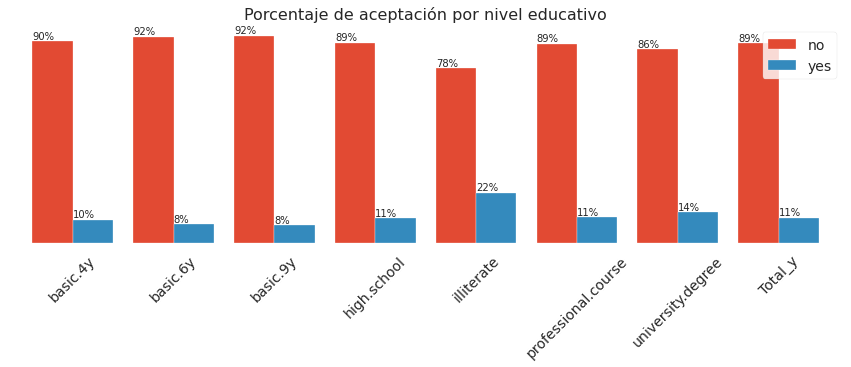

In [17]:
ax = (Tabla[["no", "yes"]]).plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
plt.legend(labels=Tabla.columns,fontsize= 14)
plt.title("Porcentaje de aceptación por nivel educativo",fontsize= 16)

plt.xticks(fontsize=14, rotation=45)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (x, y + height + 0.01))

Parece que la población perteneciente a un nivel educativo superior o igual a high_school son los más propensos a aceptar respecto a los que no. Sin embargo, los iletrados son los miembros del nivel educativo que más aceptan.

### Hipótesis 2

#### Frecuencias relativas totales

In [18]:
freq_total('marital',df)

no       yes  Total_marital
divorced  0.100771  0.011714       0.112485
married   0.544960  0.061211       0.606171
single    0.242934  0.038410       0.281344
Total_y   0.888665  0.111335       1.000000

#### Frecuencias relativas a la columna

In [19]:
freq_relativCol('marital',df)

no       yes  Total_marital
divorced  0.113396  0.105214       0.112485
married   0.613234  0.549789       0.606171
single    0.273369  0.344998       0.281344
Total_y   1.000000  1.000000       1.000000

#### Frecuencias relativas a la fila

In [20]:
Tabla = freq_relativFil('marital',df)
Tabla

no       yes  Total_marital
divorced  0.895862  0.104138            1.0
married   0.899021  0.100979            1.0
single    0.863476  0.136524            1.0
Total_y   0.888665  0.111335            1.0

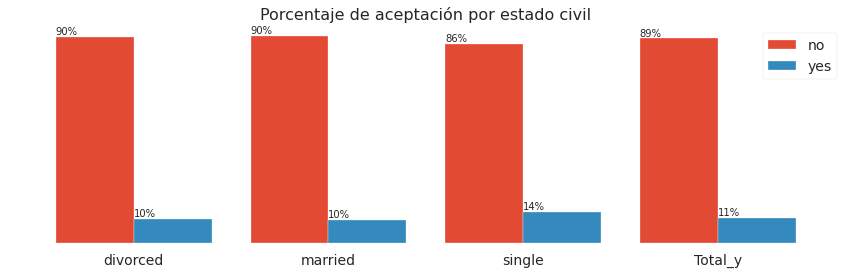

In [21]:
ax = (Tabla[["no", "yes"]]).plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
plt.legend(labels=Tabla.columns,fontsize= 14)
plt.title("Porcentaje de aceptación por estado civil",fontsize= 16)

plt.xticks(fontsize=14, rotation=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (x, y + height + 0.01))

Parece que las personas casadas o divorciadas aceptan en igual medida pero menos con respecto a los solteros.

### Hipótesis 3

#### Frecuencias relativas totales

In [22]:
freq_total('housing',df)

no       yes  Total_housing
no       0.412080  0.049863       0.461943
yes      0.476585  0.061472       0.538057
Total_y  0.888665  0.111335       1.000000

#### Frecuencias relativas a la columna

In [23]:
freq_relativCol('housing',df)

no       yes  Total_housing
no       0.463707  0.447863       0.461943
yes      0.536293  0.552137       0.538057
Total_y  1.000000  1.000000       1.000000

#### Frecuencias relativas a la fila

In [24]:
Tabla = freq_relativFil('housing',df)
Tabla

no       yes  Total_housing
no       0.892059  0.107941            1.0
yes      0.885752  0.114248            1.0
Total_y  0.888665  0.111335            1.0

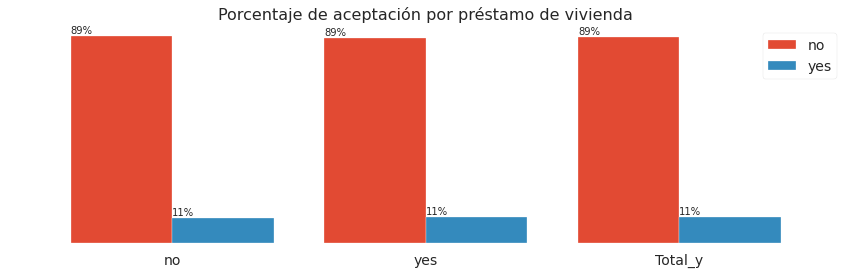

In [25]:
ax = (Tabla[["no", "yes"]]).plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
plt.legend(labels=Tabla.columns,fontsize= 14)
plt.title("Porcentaje de aceptación por préstamo de vivienda",fontsize= 16)

plt.xticks(fontsize=14, rotation=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (x, y + height + 0.01))

Parece que el tener un préstamo de vivienda o no no afecta la aceptación 

### Hipótesis 4

#### Frecuencias relativas totales

In [26]:
freq_total('loan',df)

no       yes  Total_loan
no       0.749562  0.094627    0.844189
yes      0.139103  0.016708    0.155811
Total_y  0.888665  0.111335    1.000000

#### Frecuencias relativas a la columna

In [27]:
freq_relativCol('loan',df)

no      yes  Total_loan
no       0.84347  0.84993    0.844189
yes      0.15653  0.15007    0.155811
Total_y  1.00000  1.00000    1.000000

#### Frecuencias relativas a la fila

In [28]:
Tabla = freq_relativFil('loan',df)
Tabla

no       yes  Total_loan
no       0.887908  0.112092         1.0
yes      0.892767  0.107233         1.0
Total_y  0.888665  0.111335         1.0

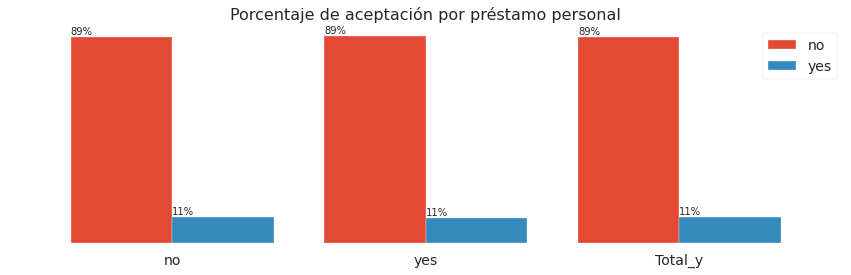

In [29]:
ax = (Tabla[["no", "yes"]]).plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
plt.legend(labels=Tabla.columns,fontsize= 14)
plt.title("Porcentaje de aceptación por préstamo personal",fontsize= 16)

plt.xticks(fontsize=14, rotation=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (x, y + height + 0.01))

Parece que el tener un préstamo personal no afecta la aceptación.

## Validación hipótesis

Las hipótesis a validar seleccionadas son las dos primeras

*  Hipótesis 1: El nivel educativo está relacionado con la aceptación de estas campañas por parte de los clientes, entre más alto mayor aceptación puede haber.

*  Hipótesis 2: El estado civil está relacionado con la aceptación de estas campañas por parte de los clientes, entre más comprometido mayor aceptación puede haber.

In [30]:
def contingencia(col,df):
  Tabla = pd.crosstab(index=df[col],columns=df["y"])
  return Tabla

def chiquad(Tabla, prob = 0.95):
  estadistico, p_value, grados_libertad, freq_esperadas = chi2_contingency(Tabla)
  print(f"El estadístico de prueba es {estadistico}, el p_value es {p_value}, los grados de libertad {grados_libertad} y las frecuencias esperadas son:\n {freq_esperadas}")
  print("Interpretando p_value con probabilidad del {}%".format(prob*100))
  alpha = 1.0 - prob
  if p_value <= alpha:
    print('Dependientes (Se rechaza H0)')
  else:
    print('No son dependientes (No se puede rechazar H0)')
  print("Interpretando estadístico de prueba con probabilidad del {0}% y {1} grados de libertad".format(prob*100,grados_libertad))
  # interpret test-statistic
  critical = chi2.ppf(prob, grados_libertad)
  if abs(estadistico) >= critical:
    print('Dependientes (Se rechaza H0)')
  else:
    print('No son dependientes (No se puede rechazar H0)')

### Hipótesis 1

H0: Las variables _education_ y _y_ son independientes

H1: Las variables _education_ y _y_ no son independientes

In [31]:
Tabla = contingencia("education",df)
chiquad(Tabla)

El estadístico de prueba es 170.01425619488032, el p_value es 4.4665371241673025e-34, los grados de libertad 6 y las frecuencias esperadas son:
 [[3.55643807e+03 4.45561930e+02]
 [1.95861807e+03 2.45381932e+02]
 [5.20402332e+03 6.51976677e+02]
 [8.21482097e+03 1.02917903e+03]
 [1.59959733e+01 2.00402667e+00]
 [4.53219244e+03 5.67807557e+02]
 [1.05049112e+04 1.31608885e+03]]
Interpretando p_value con probabilidad del 95.0%
Dependientes (Se rechaza H0)
Interpretando estadístico de prueba con probabilidad del 95.0% y 6 grados de libertad
Dependientes (Se rechaza H0)


Las variables _education_ y _y_ no son independientes

### Hipótesis 2

H0: Las variables _marital_ y _y_ son independientes

H1: Las variables _marital_ y _y_ no son independientes

In [32]:
Tabla = contingencia("marital",df)
chiquad(Tabla)

El estadístico de prueba es 96.38458503893935, el p_value es 1.1758536958018105e-21, los grados de libertad 2 y las frecuencias esperadas son:
 [[ 3823.03762583   478.96237417]
 [20601.92498366  2581.07501634]
 [ 9562.03739051  1197.96260949]]
Interpretando p_value con probabilidad del 95.0%
Dependientes (Se rechaza H0)
Interpretando estadístico de prueba con probabilidad del 95.0% y 2 grados de libertad
Dependientes (Se rechaza H0)


Las variables _marital_ y _y_ no son independientes

## Estrategia propuesta

La estrategia propuesta dada la relación de las variables _education_ y _marital_ con la variable _y_ (aceptación de la suscripción al depósito) debe ser una campaña dirigida a personas iletradas o con nivel educativo superior o igual a high school y que sean solteras aunque también pueden ser personas casadas y divorciadas pues la proporción de personas que aceptaron previamente no varia mucho entre los estados civiles anteriormente mencionados.